# The Curse of Dimensionality and Adaptive Sparse Grids

Julien Pascal: https://julienpascal.github.io/

Notebook for the blog post here: https://julienpascal.github.io/post/asg/

## Python version of the code

With **Python**, I use the package **Tasmanian**:

* https://pypi.org/project/Tasmanian/

The code is based on this paper: 

* https://github.com/SparseGridsForDynamicEcon/SparseGrids_in_econ_handbook/blob/master/doc/sparse_grids_in_econ.pdf

* https://github.com/SparseGridsForDynamicEcon/SparseGrids_in_econ_handbook

I made small modifications (e.g. vectorization of the code)


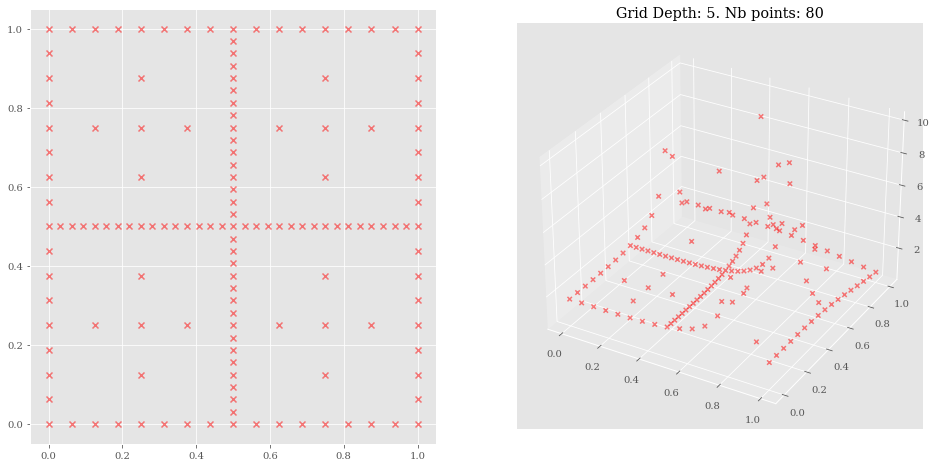

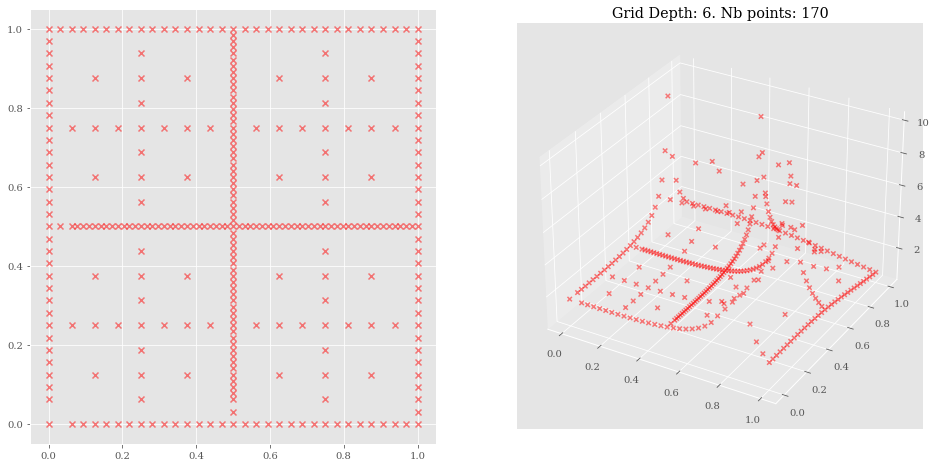

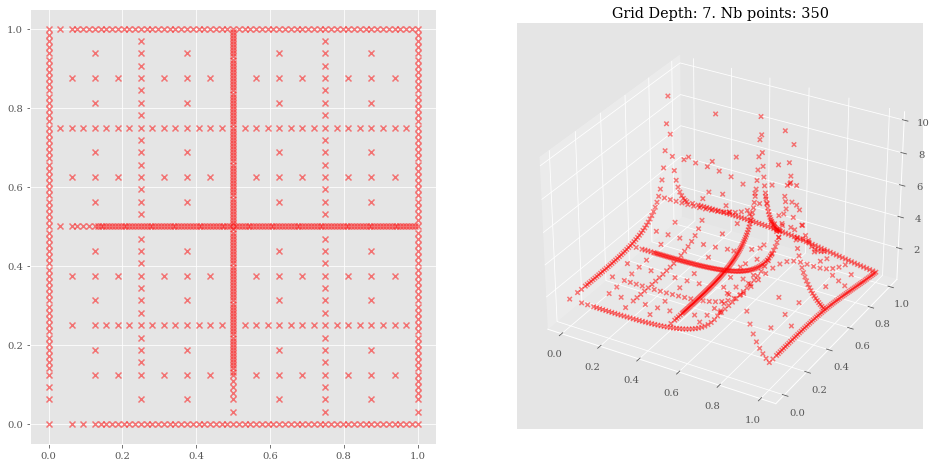

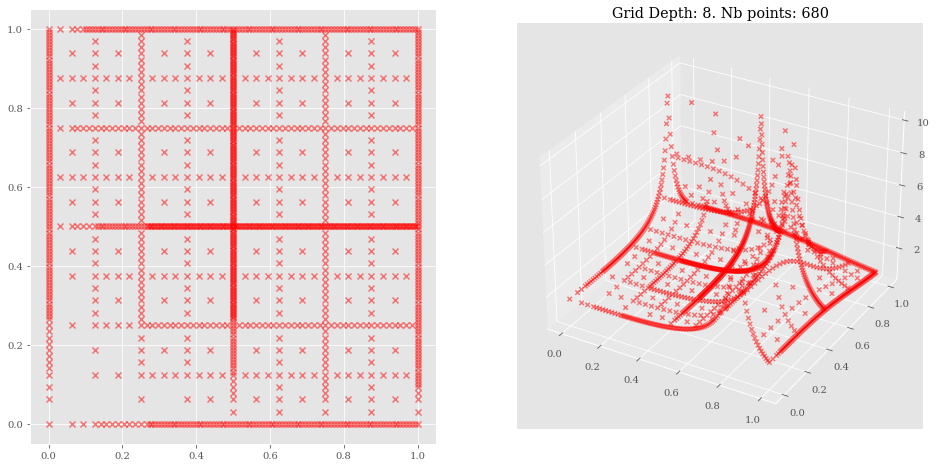

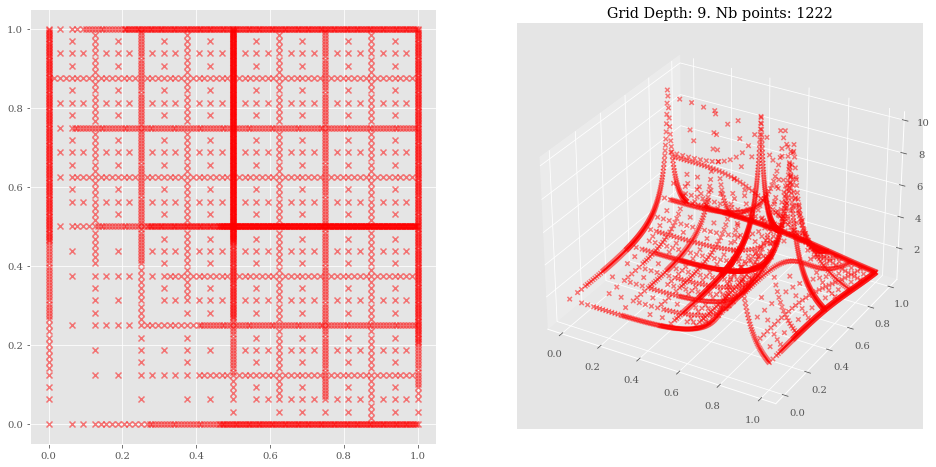

In [212]:
################################################################################
#                        Load necessary libraries                              #
################################################################################
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
plt.style.use('ggplot')

import Tasmanian # sparse grids
import numpy as np
from scipy.interpolate import RegularGridInterpolator #Linear interpoulation regular grid

from scipy.stats import norm, lognorm
import numpy as np
import chaospy #Numerical integration

################################################################################
#                                                                              #
#                     Setup                     
#                                                                              #
################################################################################

# Types of base functions for local sparse grids (see TASMANIAN documentation for
# more details)
#['localp', 'semi-localp', 'localp-zero', 'localp-boundary']

# Number of dimensions
gridDim = 2
# Number of outputs
gridOut = 1
# Grid level (note that counting starts at 0; we vary the level from 6 to 16)
gridDepthGrid = [5,6,7,8,9]
# 1=linear, 2=quadratic, 3=cubic
gridOrder = 1
# Type of base functions
gridRule = "localp"

# Domain of the grid (default for local grids is [-1,1]^n)
gridDomain = np.zeros((gridDim,2))
gridDomain[:,1] = 1.0

# Set random seed and number of draws
np.random.seed(seed=28092021)
TT = 10000

# Draw random numbers
evalPoints = np.random.rand(TT,gridDim)

# Number of distinct gridDepth values
noDepth = len(gridDepthGrid)

# Preallocation of error arrays
l1ErrorNSG = np.zeros(noDepth)
l2ErrorNSG = np.zeros(noDepth)
lInfErrorNSG = np.zeros(noDepth)
# Array to store the resp. number of grid points
NSGPoints = np.zeros(noDepth,dtype=int)

# Index for grid_depth
i0 = 0

# Adaptive Sparse Gridpoints
# Number of dimensions
gridDim = 2
# Number of outputs
gridOut = 1
# Grid level (we start with a sparse grid of level 3)
gridDepthASG = 2
# 1=linear, 2=quadratic, 3=cubic
gridOrder = 1
# Type of base functions
gridRule = "localp"

# Threshold for refinements
surplThreshold = 1e-5

# Preallocation of error arrays
l1ErrorNASG = np.zeros(noDepth)
l2ErrorNASG = np.zeros(noDepth)
lInfErrorNASG = np.zeros(noDepth)
# Array to store the resp. number of grid points
NASGPoints = np.zeros(noDepth,dtype=int)

# Loop over different possible refinement levels
for (i0, gridDepth) in enumerate(gridDepthGrid): 

    # Generate the grid structure
    gridNASG = Tasmanian.makeLocalPolynomialGrid(gridDim, gridOut, gridDepthASG, gridOrder,gridRule)
    # Transform the domain
    gridNASG.setDomainTransform(gridDomain)
    # Index of current grid level to control the number of refinements
    ilev = gridDepthASG

    while ((gridNASG.getNumNeeded() > 0) and (ilev<=gridDepth)):

        # Get the points that require function values
        aPointsNASG = gridNASG.getNeededPoints()
        # Get the number of points that require function values
        aNumAdd = gridNASG.getNumNeeded()

        # Preallocation of function values array
        fValuesNASG = np.zeros((aNumAdd,gridOut))

        # Non-vectorized
        #for i1 in range(aNumAdd): 
        #    fValuesNASG[i1] = 1.0/(np.abs(0.5 - aPointsNASG[i1,0]**4 - aPointsNASG[i1,1]**4) + 0.1)
        
        # Vectorized:
        fValuesNASG = 1.0/(np.abs(0.5 - aPointsNASG[:,0]**4 - aPointsNASG[:,1]**4) + 0.1)
        # Add a useless extra dimension for Tasmanian
        fValuesNASG = np.expand_dims(fValuesNASG, 1)
            
        # Load function values into the grid structure
        gridNASG.loadNeededPoints(fValuesNASG)
        
        # Refine the grid based on the surplus coefficients
        gridNASG.setSurplusRefinement(surplThreshold, -1, "classic")
        # Track the grid level
        ilev += 1
    
    # Store the number of grid points
    NASGPoints[i0] = gridNASG.getNumPoints()
    
    # Preallocation of arrays
    fTrueNASG = np.zeros(TT)
    fImpNASG = np.zeros(TT)

    # Loop over random evaluation points
    for i1 in range(TT):

        # Compute the exact function values at the random evaluation points
        # f(x) = 1.0/(abs(0.5 - x[1]^4 - x[2]^4) + 0.1)
        fTrueNASG[i1] = 1.0/(np.abs(0.5 - evalPoints[i1,0]**4 - evalPoints[i1,1]**4) + 0.1)
        # OLD
        #fTrueNASG[i1] = np.maximum(0.0,1.0 - np.exp(0.5-np.prod(evalPoints[i1,:]+0.2)**(1.0/gridDim)))
        # Interpolate the adaptive sparse grid at the random evaluation points
        fImpNASG[i1] = gridNASG.evaluate(evalPoints[i1,:])[0]
        
    fTrueNASG = 1.0/(np.abs(0.5 - evalPoints[:,0]**4 - evalPoints[:,1]**4) + 0.1)
    # Add a useless extra dimension for Tasmanian
    fTrueNASG = np.expand_dims(fTrueNASG, 1)
    # Interpolate the adaptive sparse grid at the random evaluation points
    fImpNASG = gridNASG.evaluateBatch(evalPoints)
        
    aPointsNASG_plot = gridNASG.getPoints()
    fValuesNASG_plot = gridNASG.getLoadedValues()

    fig = plt.figure(figsize=(16,8))
    # First subplot
    ax = fig.add_subplot(1,2,1)
    ax.scatter(aPointsNASG_plot[:,0],aPointsNASG_plot[:,1],marker='x',color='red',alpha=0.5)

    # Second subplot
    ax = fig.add_subplot(1,2,2, projection='3d')
    ax.scatter(aPointsNASG_plot[:,0],aPointsNASG_plot[:,1],fValuesNASG_plot,\
               marker='x',color='red',alpha=0.5)
    
    plt.title("Grid Depth: {}. Nb points: {}".format(gridDepth, len(fValuesNASG)))
    plt.show()
    
    # Compute the L1-error
    l1ErrorNASG[i0] = (1.0/TT)*np.sum(np.abs(fTrueNASG-fImpNASG))
    # Compute the L2-error
    l2ErrorNASG[i0] = ((1.0/TT)*np.sum(np.abs(fTrueNASG-fImpNASG)**2))**0.5
    # Compute the LInf-error as the 99.9 percent quantile of the error distribution
    lInfErrorOrder = np.sort(np.abs(fTrueNASG-fImpNASG),axis=None)
    lInfErrorNASG[i0] = np.amax(lInfErrorOrder[:-10])



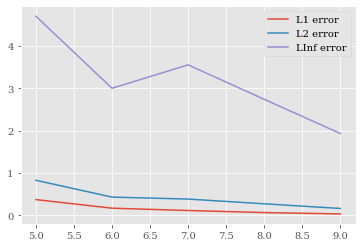

In [211]:
plt.plot(gridDepthGrid, l1ErrorNASG, label="L1 error")
plt.plot(gridDepthGrid, l2ErrorNASG, label="L2 error")
plt.plot(gridDepthGrid, lInfErrorNASG, label="LInf error")
plt.legend()

## Model

See https://julienpascal.github.io/post/asg/ for details.

In [146]:

class Params:
    def __init__(self):
        self.x_min = 0.0
        self.x_max = 1.0
        self.y_min = 0.0
        self.y_max = 1.0
        self.nx = 21
        self.ny = 21
        self.nz = 10
        self.dt = 1.0 / 52.0
        self.r = (1.0 + 0.05) ** self.dt - 1.0
        self.delta = 0.0127012273
        self.epsilon = 0.001
        self.x_grid = np.linspace(self.x_min + self.epsilon, self.x_max - self.epsilon, self.nx)
        self.y_grid = np.linspace(self.y_min + self.epsilon, self.y_max - self.epsilon, self.ny)
        self.rho = 0.9997369438
        self.sigma = 0.0714488990
        self.psi = self.sigma * np.sqrt(1.0 - self.rho ** 2)
        self.distrib_innovation = chaospy.Normal(mu=0, sigma=self.psi)
        # Use chaopsy for the expectation operator
        self.nb_nodes = 10 #number nodes 
        # nodes and weigths
        self.nodes_E, self.weigths_E = chaospy.generate_quadrature(self.nb_nodes-1, self.distrib_innovation, rule ="gaussian")
        # Remove an extra dim to self.nodes_E
        self.nodes_E = self.nodes_E[0]
        self.f0 = 6.0873503685
        self.f1 = 0.0025488557
        self.f2 = 2.0529182143
        self.f3 = -0.1400252578
        self.f4 = 8.0349795180
        self.f5 = -1.9072145913
        self.f6 = 6.5961298483
        self.b0 = 0.7
        self.z_min = lognorm.ppf(0.05, self.sigma)
        self.z_max = lognorm.ppf(0.95, self.sigma)
        self.lower_bound = [self.x_min, self.y_min, self.z_min]
        self.upper_bound = [self.x_max, self.y_max, self.z_max]
        self.z_grid = np.linspace(self.z_min, self.z_max, self.nz)
        self.nodes_xyz = (self.x_grid, self.y_grid, self.z_grid)

    # Define your functions here as methods inside the Params class, using Python syntax.
    # For example:
    def p_xyz(self, x, y, z):
        return self.f0 * z * (self.f1 + self.f2 * x + self.f3 * y + self.f4 * (x ** 2) + self.f5 * (y ** 2) + self.f6 * x * y) * self.dt

    def b_x(self, x):
        return self.b0 * self.p_xyz(x, x, 1.0)

    def s_xyz(self, x, y, z):
        return self.p_xyz(x, y, z) - self.b_x(x)

    # Add other necessary methods here.


In [169]:
p = Params()
p.nodes

array([-0.00796333, -0.00586963, -0.00407113, -0.00240235, -0.00079468,
        0.00079468,  0.00240235,  0.00407113,  0.00586963,  0.00796333])

In [173]:
np.sum(p.nodes_E)

-3.469446951953614e-18

In [175]:
p.weigths_E

array([4.31065263e-06, 7.58070934e-04, 1.91115805e-02, 1.35483703e-01,
       3.44642335e-01, 3.44642335e-01, 1.35483703e-01, 1.91115805e-02,
       7.58070934e-04, 4.31065263e-06])

In [194]:
# Non Vectorized code
# VERY SLOW
def solve_VFI(p: Params, max_iter: int = 1000, tol: float = 1e-8, show_every: int = None):
    
    V_old = np.zeros((p.nx, p.ny, p.nz))
    V_new = np.zeros((p.nx, p.ny, p.nz))

    # Initial guess
    for zIndex, zValue in enumerate(p.z_grid):
        for yIndex, yValue in enumerate(p.y_grid):
            for xIndex, xValue in enumerate(p.x_grid):
                V_old[xIndex, yIndex, zIndex] = p.s_xyz(xValue, yValue, zValue) + ((1.0 - p.delta)/(1.0 + p.r)) * max(0.0, p.s_xyz(xValue, yValue, zValue))

    itp = RegularGridInterpolator(p.nodes_xyz, V_old, method='linear', bounds_error=False, fill_value=None)
    
    def V_old_interpolated(x):
        x = np.atleast_2d(x)
        # Clip the input values to be within the bounds
        #x_clipped = np.column_stack([np.clip(x[:, i], p.nodes_xyz[i][0], p.nodes_xyz[i][-1]) for i in range(x.shape[1])])
        return itp(x)

    if show_every is None:
        show_every = max_iter

    # Main loop
    for i in range(1, max_iter + 1):
        for zIndex, zValue in enumerate(p.z_grid):
            for yIndex, yValue in enumerate(p.y_grid):
                for xIndex, xValue in enumerate(p.x_grid):
                    V_new[xIndex, yIndex, zIndex] = p.s_xyz(xValue, yValue, zValue) + ((1.0 - p.delta)/(1.0 + p.r)) * np.sum(p.weigths_E * np.array([np.maximum(0.0, V_old_interpolated([xValue, yValue, (zValue ** p.rho) * np.exp(innovation)])[0]) for innovation in p.nodes_E]))

        # Distance
        diff = np.max(np.abs(V_new - V_old))
        if i % show_every == 0:
            print(f"Iter {i} Diff : {diff}")

        if diff < tol:
            print(f"Iter {i} Convergence reached")
            break

        # Update
        V_old = np.copy(V_new)
        itp = RegularGridInterpolator(p.nodes_xyz, V_old, method='linear', bounds_error=False, fill_value=None)

    # Return value function
    return V_old_interpolated


In [196]:
# Vectorized code
def solve_VFI(p: Params, max_iter: int = 1000, tol: float = 1e-8, show_every: int = None):
        """
    Solve the value function iteration problem using vectorization for improved performance.

    Args:
        p (Params): An instance of the Params class, which contains the model's parameters.
        max_iter (int, optional): The maximum number of iterations to perform. Defaults to 1000.
        tol (float, optional): The tolerance for convergence. The iteration stops when the
            maximum difference between consecutive value function updates is less than `tol`.
            Defaults to 1e-8.
        show_every (int, optional): If specified, print the iteration number and the maximum
            difference between consecutive value function updates every `show_every` iterations.
            If not specified or None, this information is printed at every iteration.

    Returns:
        RegularGridInterpolator: An interpolator object that represents the solution to the
            value function iteration problem. This object can be used to interpolate the
            value function at arbitrary (x, y, z) points within the domain.
    """
    V_old = np.zeros((p.nx, p.ny, p.nz))
    V_new = np.zeros((p.nx, p.ny, p.nz))

    X, Y, Z = np.meshgrid(p.x_grid, p.y_grid, p.z_grid, indexing='ij')

    S = p.s_xyz(X, Y, Z)

    V_old = S + ((1.0 - p.delta) / (1.0 + p.r)) * np.maximum(0, S)

    if show_every is None:
        show_every = max_iter

    for i in range(1, max_iter + 1):
        itp = RegularGridInterpolator(p.nodes_xyz, V_old, method='linear', bounds_error=False, fill_value=None)

        V_old_innov_accum = np.zeros_like(V_old)

        for innovation, weight in zip(p.nodes_E, p.weigths_E):
            X_innov = X
            Y_innov = Y
            Z_innov = (Z ** p.rho) * np.exp(innovation)

            V_old_innov = itp(np.column_stack([X_innov.ravel(), Y_innov.ravel(), Z_innov.ravel()])).reshape(X_innov.shape)

            V_old_innov_accum += weight * np.maximum(0, V_old_innov)

        V_new = S + ((1.0 - p.delta) / (1.0 + p.r)) * V_old_innov_accum

        diff = np.max(np.abs(V_new - V_old))

        if i % show_every == 0:
            print(f"Iter {i} Diff : {diff}")

        if diff < tol:
            print(f"Iter {i} Convergence reached")
            break

        V_old = V_new.copy()

    return itp


In [204]:
%%time
V_sol = solve_VFI(p, 5000, 1e-8, 50)

Iter 50 Diff : 0.35941383066083077
Iter 100 Diff : 0.18029186493440363
Iter 150 Diff : 0.09044289028266661
Iter 200 Diff : 0.04537214987943372
Iter 250 Diff : 0.022762534662668088
Iter 300 Diff : 0.011420048930737892
Iter 350 Diff : 0.005729690506306895
Iter 400 Diff : 0.002874815723700408
Iter 450 Diff : 0.001442461797644512
Iter 500 Diff : 0.0007237922305662892
Iter 550 Diff : 0.00036319398092388155
Iter 600 Diff : 0.0001822545367957673
Iter 650 Diff : 9.146035717577661e-05
Iter 700 Diff : 4.589888606432169e-05
Iter 750 Diff : 2.303488133748033e-05
Iter 800 Diff : 1.1560703775614911e-05
Iter 850 Diff : 5.802256332287925e-06
Iter 900 Diff : 2.9122172975348803e-06
Iter 950 Diff : 1.461721936379945e-06
Iter 1000 Diff : 7.337021159514734e-07
Iter 1050 Diff : 3.6828894423024394e-07
Iter 1100 Diff : 1.8487210695639078e-07
Iter 1150 Diff : 9.28042354075842e-08
Iter 1200 Diff : 4.6588404245540005e-08
Iter 1250 Diff : 2.3388444958527543e-08
Iter 1300 Diff : 1.1741903449546953e-08
Iter 1312 Co

Iter 1000 Diff : 7.337021159514734e-07


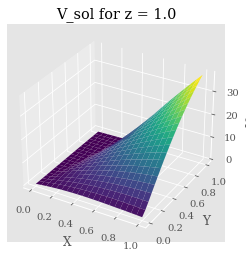

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

p = Params()
V_sol = solve_VFI(p)

# Get V_sol values for z = 1.0
x_grid, y_grid = np.meshgrid(p.x_grid, p.y_grid)
z_fixed = np.ones_like(x_grid)
V_sol_z_fixed = V_sol(np.column_stack([x_grid.ravel(), y_grid.ravel(), z_fixed.ravel()])).reshape(x_grid.shape)

# Create a surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, V_sol_z_fixed, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('V_sol')
ax.set_title('V_sol for z = 1.0')
plt.show()

Iter 1000 Diff : 7.337021159514734e-07


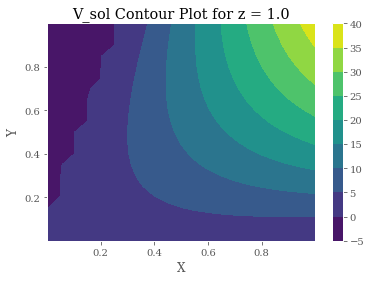

In [207]:
import numpy as np
import matplotlib.pyplot as plt

p = Params()
V_sol = solve_VFI(p)

# Get V_sol values for z = 1.0
x_grid, y_grid = np.meshgrid(p.x_grid, p.y_grid)
z_fixed = np.ones_like(x_grid)
V_sol_z_fixed = V_sol(np.column_stack([x_grid.ravel(), y_grid.ravel(), z_fixed.ravel()])).reshape(x_grid.shape)

# Create a contour plot
fig, ax = plt.subplots()
contour = ax.contourf(x_grid, y_grid, V_sol_z_fixed, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('V_sol Contour Plot for z = 1.0')
fig.colorbar(contour)
plt.show()
